# Advanced DL and RL: Домашнее задание 1

In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from blackjack import BlackjackEnv

## Часть первая, с блекджеком и стратегиями

In [2]:
def run_episode(env, pi):
    env.reset()
    states, rewards, actions = [env._get_obs()], [0], []

    for _ in range(30):
        action = pi(env)
        observation, reward, done, info = env.step(action)
        states.append(observation)
        rewards.append(reward)
        actions.append(action)
            
        if done:
            break

    return states, rewards, actions

In [3]:
def run_experiments(env, pi, num_experiments=100000):
    num_steps, total_reward = np.array([0.0] * num_experiments), np.array([0.0] * num_experiments)

    for i in range(num_experiments):
        states, rewards, _ = run_episode(env, pi)
        num_steps[i] = len(states) - 1
        total_reward[i] = rewards[-1]

    mean_reward = np.mean(total_reward)
    mean_num_steps = np.mean(num_steps)

    print("\nСредняя награда: %.6f\nСреднее число шагов: %.6f\n" % \
        (mean_reward, mean_num_steps))

    return mean_reward, mean_num_steps

Попробуем оценить выигрыш казино в случае, когда игрок будет делать случайное действия.

In [4]:
def random_pi(env):
    """    
    return 0, 1
    """
    return np.int(np.random.rand() * 2)

In [5]:
env = BlackjackEnv()
run_experiments(env, random_pi);


Средняя награда: -0.393980
Среднее число шагов: 1.383730



Получилось, что при такой игре казино в среднем забирает примерно 0.4 ставки игрока. Для казино это достаточно прибыльно.

Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit.

In [6]:
def smart_pi(env):
    player, dealer, usable_ace = env._get_obs()
    return np.int(player < 19)

In [7]:
env = BlackjackEnv()
run_experiments(env, smart_pi);


Средняя награда: -0.200890
Среднее число шагов: 1.739720



Таким образом получаем, что подобная, на первый взгляд неплохая, стратегия действительно учеличивает средний выигрыш по сравнению со случайными действиями с 0.4 до 0.2 ставки в пользу казино. Однако казино все еще очень сильно выигрывает.

### Monte Carlo control with exploring starts

Теперь попробуем обучить какую-то более "умную" стратегию.  
Для этого начнем генерировать эпизоды по случайной стратегии. В каждом эпизоде обходя позиции с конца запоминать полученную награду для каждого действия. Если это действие несоответствовало нашей стратегии, то обработка эпизода прекращается. Не используется дисконт по номеру действия. Т.е. принят коэффициент гамма = 1 т.к. скорость принятие решения в этой игре не важна.  

Затем периодически обновлять свою стратегию по имеющимся оценкам следующим образом:   

* Для известных позиций по каждому действию вычисляется средняя полученная награда. Если для конкретной позиции были рассмотрены не все действия - их награда оценивается нулем.  

* С небольшим шансом делается случайное действие, чтобы сохранить возможность исследовать окружение. Если позиция известна - выбирается наилучшее действие по оценкам награды. Иначе - случайное действие.  

В таком случае при небольшом количестве возможных стостояний, а в этой игре их не так уж много, мы сможем в начале получить достаточно опыта. Далее нужно больше следовать стратегии, поэтому случайная стратегия постепенно заменяется на мягкую. Таким образом оценки получаются довольно точными т.к. игра неглубокая и очень редко когда бывает больше 2 ходов у игрока. 

In [8]:
def update_returns_actions(rewards_list, states, rewards, actions):
    for i in range(len(states) - 2, -1, -1):
        state = states[i]
        try:
            rewards_list[state][actions[i]].append(rewards[-1])
        except:
            rewards_list[state] = [[0], [0]]
            rewards_list[state][actions[i]].append(rewards[-1])
        
        actions_reward = np.array([np.mean(action) for action in rewards_list[state]])        
        if not(np.argmax(actions_reward) == actions[i]):
            break


def calc_Q_by_reward(rewards_list):
    Q = {}
    for state, actions in rewards_list.items():
        Q[state] = np.array([np.mean(action) for action in actions])
    return Q


def calc_pi_by_reward(rewards_list):
    pi = {}
    for state, actions in rewards_list.items():
        actions_reward = np.array([np.mean(action) for action in actions])
        pi[state] = np.argmax(actions_reward)
    return pi
 
pi = {}
def monte_carlo_pi(env):
    try:
        return pi[env._get_obs()]
    except:
        return random_pi(env)


def eps_monte_carlo_pi(env):
    eps = 0.05
    if np.random.rand() < eps:
        return random_pi(env)

    try:
        return pi[env._get_obs()]
    except:
        return random_pi(env)


def plot_results(mean_rewards, mean_num_steps, episodes):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax2 = ax.twinx()
    ax.grid(None)

    line1 = ax.plot(episodes, mean_rewards, label="Средние награды", color="C0")
    line2 = ax2.plot(episodes, mean_num_steps, label="Среднее число шагов", color="C1")

    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc=2)
    ax.set_xlim((episodes[0], episodes[-1]))
    ax.set_title("Monte Carlo control with exploring starts", fontdict={'fontsize': 20})
    return fig, ax

In [16]:
env = BlackjackEnv()
total_episodes = 240000
total_points = 20 + 1

mean_rewards, mean_num_steps = np.array([0.0] * total_points), np.array([0.0] * total_points) 
episodes = np.arange(0, total_episodes + 1, total_episodes // (total_points - 1))

reward_list = {}
pi = {}
j = 0

for i in range(total_episodes + 1):
    states, rewards, actions = run_episode(env, eps_monte_carlo_pi)
    update_returns_actions(reward_list, states, rewards, actions)

    if i % (total_episodes // (total_points - 1)) == 0:
        print(f"episod: {i}")
        pi = calc_pi_by_reward(reward_list)
        mean_rewards[j], mean_num_steps[j] = run_experiments(env, monte_carlo_pi)
        j += 1

episod: 0

Средняя награда: -0.388630
Среднее число шагов: 1.375620

episod: 12000

Средняя награда: -0.088400
Среднее число шагов: 1.333450

episod: 24000

Средняя награда: -0.076460
Среднее число шагов: 1.364110

episod: 36000

Средняя награда: -0.077120
Среднее число шагов: 1.366480

episod: 48000

Средняя награда: -0.072030
Среднее число шагов: 1.380630

episod: 60000

Средняя награда: -0.064080
Среднее число шагов: 1.394640

episod: 72000

Средняя награда: -0.066250
Среднее число шагов: 1.416950

episod: 84000

Средняя награда: -0.060940
Среднее число шагов: 1.418930

episod: 96000

Средняя награда: -0.060370
Среднее число шагов: 1.448770

episod: 108000

Средняя награда: -0.058280
Среднее число шагов: 1.451100

episod: 120000

Средняя награда: -0.054400
Среднее число шагов: 1.469030

episod: 132000

Средняя награда: -0.052190
Среднее число шагов: 1.467140

episod: 144000

Средняя награда: -0.050990
Среднее число шагов: 1.465910

episod: 156000

Средняя награда: -0.046610
Среднее 

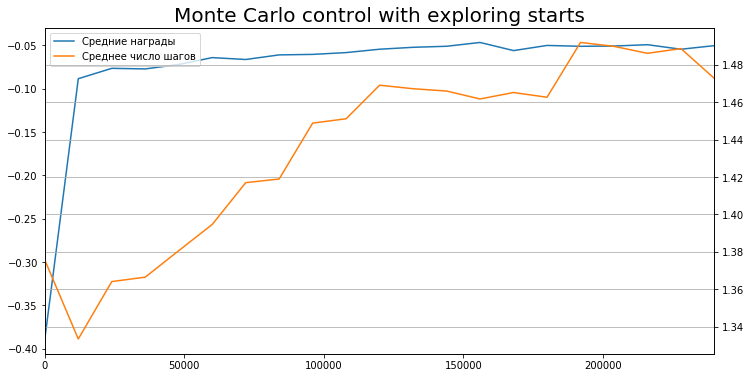

In [17]:
fig, ax = plot_results(mean_rewards, mean_num_steps, episodes)

Выбранная стратегия довольно быстро сходится к значению выигрыша 0.05 ставки в пользу казино, что уже довольно неплохо, но все равно при таких правилах в блэкджек лучше не играть, даже если вы очень умный.  

## Часть вторая, удвоенная

Чтобы иметь больше шансов на победу, добавим возможность использовать действие double в нашем окружении, для этого переопределим несколько функций.  

In [9]:
def update_returns_actions(rewards_list, states, rewards, actions):
    for i in range(len(states) - 2, -1, -1):
        state = states[i]
        try:
            rewards_list[state][actions[i]].append(rewards[-1])
        except:
            rewards_list[state] = [[0], [0], [0]]
            rewards_list[state][actions[i]].append(rewards[-1])
        
        actions_reward = np.array([np.mean(action) for action in rewards_list[state]])        
        if not(np.argmax(actions_reward) == actions[i]):
            break


def random_pi(env):
    """
    return 0, 1, 2
    """
    return np.int(np.random.rand() * 3)

In [19]:
env = BlackjackEnv()
total_episodes = 400000
total_points = 20 + 1

mean_rewards, mean_num_steps = np.array([0.0] * total_points), np.array([0.0] * total_points) 
episodes = np.arange(0, total_episodes + 1, total_episodes // (total_points - 1))

reward_list = {}
pi = {}
j = 0

for i in range(total_episodes + 1):
    states, rewards, actions = run_episode(env, eps_monte_carlo_pi)
    update_returns_actions(reward_list, states, rewards, actions)

    if i % (total_episodes // (total_points - 1)) == 0:
        print(f"episod: {i}")
        pi = calc_pi_by_reward(reward_list)
        mean_rewards[j], mean_num_steps[j] = run_experiments(env, monte_carlo_pi)
        j += 1

episod: 0

Средняя награда: -0.447040
Среднее число шагов: 1.229840

episod: 20000

Средняя награда: -0.091670
Среднее число шагов: 1.230790

episod: 40000

Средняя награда: -0.083910
Среднее число шагов: 1.220720

episod: 60000

Средняя награда: -0.067400
Среднее число шагов: 1.221820

episod: 80000

Средняя награда: -0.070920
Среднее число шагов: 1.238380

episod: 100000

Средняя награда: -0.069670
Среднее число шагов: 1.243570

episod: 120000

Средняя награда: -0.063570
Среднее число шагов: 1.248210

episod: 140000

Средняя награда: -0.058780
Среднее число шагов: 1.266620

episod: 160000

Средняя награда: -0.061850
Среднее число шагов: 1.261000

episod: 180000

Средняя награда: -0.065230
Среднее число шагов: 1.274220

episod: 200000

Средняя награда: -0.058340
Среднее число шагов: 1.294560

episod: 220000

Средняя награда: -0.054660
Среднее число шагов: 1.297930

episod: 240000

Средняя награда: -0.054860
Среднее число шагов: 1.295530

episod: 260000

Средняя награда: -0.056090
Сред

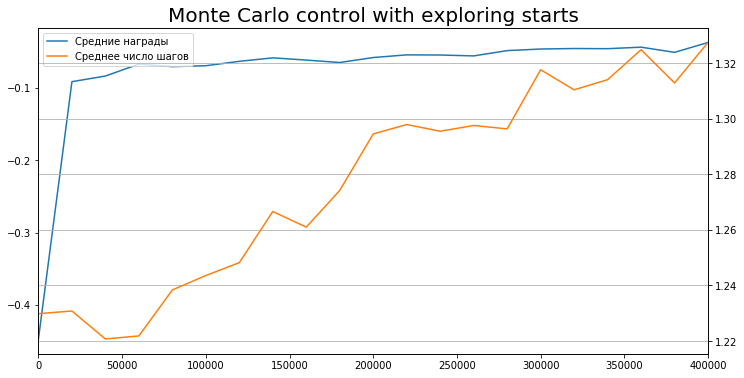

In [20]:
fig, ax = plot_results(mean_rewards, mean_num_steps, episodes)

Получен средний выигрыш в 0.037 ставки в пользу казино, что немногим лучше стратегии без использования double.

## Часть третья, в главной роли — Дастин Хоффман

Начинаем считать карты! А чтобы лучше считалось, немного увеличим параметр eps в нашей мягкой стратегии.

In [13]:
def run_episode(env, pi):
    env.reset()
    states, rewards, actions = [env._get_obs_with_deck()], [0], []

    for _ in range(30):
        action = pi(env)
        observation, reward, done, info = env.step(action)
        states.append(env._get_obs_with_deck())
        rewards.append(reward)
        actions.append(action)            
        if done:
            break

    return states, rewards, actions

def monte_carlo_pi(env):
    try:
        return pi[env._get_obs_with_deck()]
    except:
        return random_pi(env)

def eps_monte_carlo_pi(env):
    eps = 0.15
    if np.random.rand() < eps:
        return random_pi(env)

    try:
        return pi[env._get_obs_with_deck()]
    except:
        return random_pi(env)

При попытке честно считать все карты в колоде возникает проблема, что число уникальных эпизодов сильно возрастает (несколько миллионов) и для адекватного обучения требуется слишком много итераций. Был проведен эксперимент с использованием 8 миллионов эпизодов (результаты приведены ниже), но он не привел к приемлемым результатам.  

Поэтому вместо запоминания всех карт, мы будем запоминать их **средний номинал**, что тоже должно помочь в игре.  


### Попытка запоминать все карты

In [11]:
# env = BlackjackEnv()
# step_episodes = 100000
# max_do_not_imp_rounds = 20

# reward_list = {}
# pi = {}
# i = 1
# do_not_imp_rounds = 0

# mean_rewards, mean_num_steps, episodes = [0], [0], [0]
# mean_rewards[0], mean_num_steps[0] = run_experiments(env, eps_monte_carlo_pi, 10000)

# best_reward = mean_rewards[0]

# while True:
#     states, rewards, actions = run_episode(env, eps_monte_carlo_pi)
#     update_returns_actions(reward_list, states, rewards, actions)
    

#     if i % step_episodes == 0:
#         print(f"episod: {i}")
#         pi = calc_pi_by_reward(reward_list)
#         mean_r, mean_n_s = run_experiments(env, monte_carlo_pi, 10000)
#         mean_rewards.append(mean_r)
#         mean_num_steps.append(mean_n_s)
#         episodes.append(i)

#         if mean_rewards[-1] > best_reward:
#             best_reward = mean_rewards[-1]
#             do_not_imp_rounds = 0
#         else:
#             do_not_imp_rounds += 1
#             if do_not_imp_rounds >= max_do_not_imp_rounds:
#                 break

#     i += 1


Средняя награда: -0.458400
Среднее число шагов: 1.237400

episod: 100000

Средняя награда: -0.288300
Среднее число шагов: 1.247900

episod: 200000

Средняя награда: -0.209200
Среднее число шагов: 1.273200

episod: 300000

Средняя награда: -0.200600
Среднее число шагов: 1.290800

episod: 400000

Средняя награда: -0.203900
Среднее число шагов: 1.302900

episod: 500000

Средняя награда: -0.193400
Среднее число шагов: 1.304700

episod: 600000

Средняя награда: -0.159100
Среднее число шагов: 1.320300

episod: 700000

Средняя награда: -0.171700
Среднее число шагов: 1.318000

episod: 800000

Средняя награда: -0.164400
Среднее число шагов: 1.332800

episod: 900000

Средняя награда: -0.164500
Среднее число шагов: 1.324900

episod: 1000000

Средняя награда: -0.151600
Среднее число шагов: 1.341000

episod: 1100000

Средняя награда: -0.155400
Среднее число шагов: 1.331000

episod: 1200000

Средняя награда: -0.146500
Среднее число шагов: 1.329300

episod: 1300000

Средняя награда: -0.137400
Средне

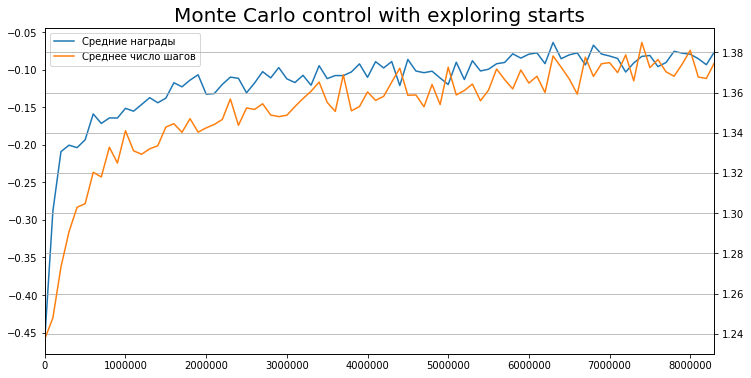

In [12]:
# fig, ax = plot_results(mean_rewards, mean_num_steps, episodes)

### Держим в памяти 'среднюю' карту

In [14]:
env = BlackjackEnv()
total_episodes = 2_000_000
total_points = 20 + 1

mean_rewards, mean_num_steps = np.array([0.0] * total_points), np.array([0.0] * total_points) 
episodes = np.arange(0, total_episodes + 1, total_episodes // (total_points - 1))

reward_list = {}
pi = {}
j = 0

for i in range(total_episodes + 1):
    states, rewards, actions = run_episode(env, eps_monte_carlo_pi)
    update_returns_actions(reward_list, states, rewards, actions)

    if i % (total_episodes // (total_points - 1)) == 0:
        print(f"episod: {i}")
        pi = calc_pi_by_reward(reward_list)
        mean_rewards[j], mean_num_steps[j] = run_experiments(env, monte_carlo_pi, 10000)
        j += 1

episod: 0

Средняя награда: -0.477700
Среднее число шагов: 1.240900

episod: 100000

Средняя награда: -0.075800
Среднее число шагов: 1.220300

episod: 200000

Средняя награда: -0.072400
Среднее число шагов: 1.237500

episod: 300000

Средняя награда: -0.061300
Среднее число шагов: 1.267600

episod: 400000

Средняя награда: -0.063200
Среднее число шагов: 1.278000

episod: 500000

Средняя награда: -0.075500
Среднее число шагов: 1.303600

episod: 600000

Средняя награда: -0.041000
Среднее число шагов: 1.306100

episod: 700000

Средняя награда: -0.018200
Среднее число шагов: 1.345400

episod: 800000

Средняя награда: -0.048100
Среднее число шагов: 1.362600

episod: 900000

Средняя награда: -0.046900
Среднее число шагов: 1.352000

episod: 1000000

Средняя награда: -0.053200
Среднее число шагов: 1.355200

episod: 1100000

Средняя награда: -0.039400
Среднее число шагов: 1.378700

episod: 1200000

Средняя награда: -0.044700
Среднее число шагов: 1.384600

episod: 1300000

Средняя награда: -0.053

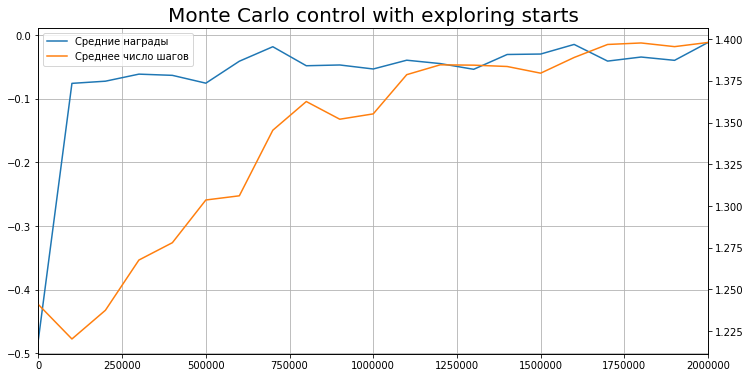

In [15]:
fig, ax = plot_results(mean_rewards, mean_num_steps, episodes)

Немного пожульничав, мы почти сравнялись с казино. Итоговый средний выигрыш составляет 0.011500 в пользу казино. К сожалению обыграть его так и не получилось. Возможно если бы была возможность полноценно считать карты и делать split - казино бы начало проигрывать, но по полученным стратегиям этого не сделать.